In [1]:
import pandas as pd
df = pd.read_csv("./df_concat(최종388개).csv")
df = df.dropna()
c = 0.2

In [2]:
df = df.drop(["name", "num","day", "day1","col"], axis = 1)

In [3]:
growth = ((df['min']-df['price1'])/df['price1'] * 100)
growth.describe()

a = growth.describe().tolist()[4]
b = growth.describe().tolist()[6]

# c = 0.9

top = b + c*(b-a)
bottom = a - c*(b-a)

df = df[(growth <= top) & (growth >= bottom)]
# df = df[df['min']>=0]
num = len(df)

In [4]:
# 색상값 1
df_col1 = pd.get_dummies(df['col1'], prefix = 'col1')
df_col2 = pd.get_dummies(df['col2'], prefix = 'col2')
df_co1_1 = pd.concat([df_col1 , df_col2], axis =1)

# 카테고리
df_category = pd.get_dummies(df['category'], prefix = 'category')

# 로우하이
df_high_low_mid = pd.get_dummies(df['high/low'], prefix = 'high/low/mid')

# 브랜드
df_brand = pd.get_dummies(df['brand'], prefix = 'brand')

# line
df_line = pd.get_dummies(df['line'], prefix = 'line')

# 성별
df_sex = pd.get_dummies(df['W1M0'], prefix = 'W1M0')

df_final_p = pd.concat([df_co1_1, df_category, df_high_low_mid, df_brand, df_line, df_sex], axis =1)

In [5]:
df_copy = df.copy().drop(["col1","col2","brand","category","high/low","W1M0","line"], axis = 1)

In [6]:
#feature importances 0 제외
# df_copy = df_copy.copy().drop(["scrap"], axis = 1)
# df_final_p = df_final_p.copy().drop(["col2_silver","col2_ivory"], axis = 1)
df_copy = df_copy.copy().drop(["scrap"], axis = 1)
df_final_p = df_final_p.copy().drop(["W1M0_w","col1_silver","col2_purple","col1_orange","category_zoomtempo","high/low/mid_mid","brand_newbalance","category_jordan 5","line_qs"], axis = 1)

In [7]:
df = pd.concat([df_copy, df_final_p], axis = 1)

In [8]:
data = df.drop("min", axis = 1)

## XGBoost

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
X = data.to_numpy()
y = df['min'].to_numpy()

In [11]:
from sklearn.model_selection import train_test_split
# 70프로를 트레이닝 셋, 30프로를 테스트 셋
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

In [12]:
# xg_reg = xgb.XGBRegressor(n_estimators = 16 ,alpha = 104, colsample_bytree = 0.9,max_depth = 6, learning_rate = 0.3)

In [13]:
xg_reg = xgb.XGBRegressor(n_estimators = 100,alpha = 179, colsample_bytree = 0.99, subsample =0.918)

In [14]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

### RMSE

In [15]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 14274.098340


In [16]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 14274.098340


In [17]:
rmse_x = rmse

In [18]:
print(c)
print(num)
print(rmse_x)

0.2
251
14274.09834015909


### predictive value & actual value

In [59]:
result = pd.DataFrame({'pred' : preds.round().astype(int), 'real' : y_test})
result.head(10)

,pred,real
0,110736,89500
1,1231211,1236667
2,489446,464000
3,168256,183500
4,255125,250000
5,403060,401800
6,216263,205000
7,112232,99333
8,245498,250000
9,114046,100000


In [53]:
result.mean()

pred    247299.802632
real    243554.118421
dtype: float64

## feature_importances

In [20]:
data_a = data.columns.tolist()

In [21]:
feature_imp = pd.Series(xg_reg.feature_importances_, index=data_a).sort_values(ascending=False)
feature_imp.head(20)

price1                 0.712061
price3                 0.119655
price2                 0.036981
category_jordan 4      0.025360
col1_purple            0.010640
col2_burgundy          0.010244
price                  0.009512
category_newbalance    0.009394
high/low/mid_high      0.007824
category_airforce      0.007446
high/low/mid_low       0.003739
col1_yellow            0.003531
col2_orange            0.003339
col1_lime              0.003064
prm                    0.002615
col2_green             0.002592
col2_pink              0.002265
col2_red               0.002030
col2_multi             0.002014
col1_blue              0.001944
dtype: float32

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


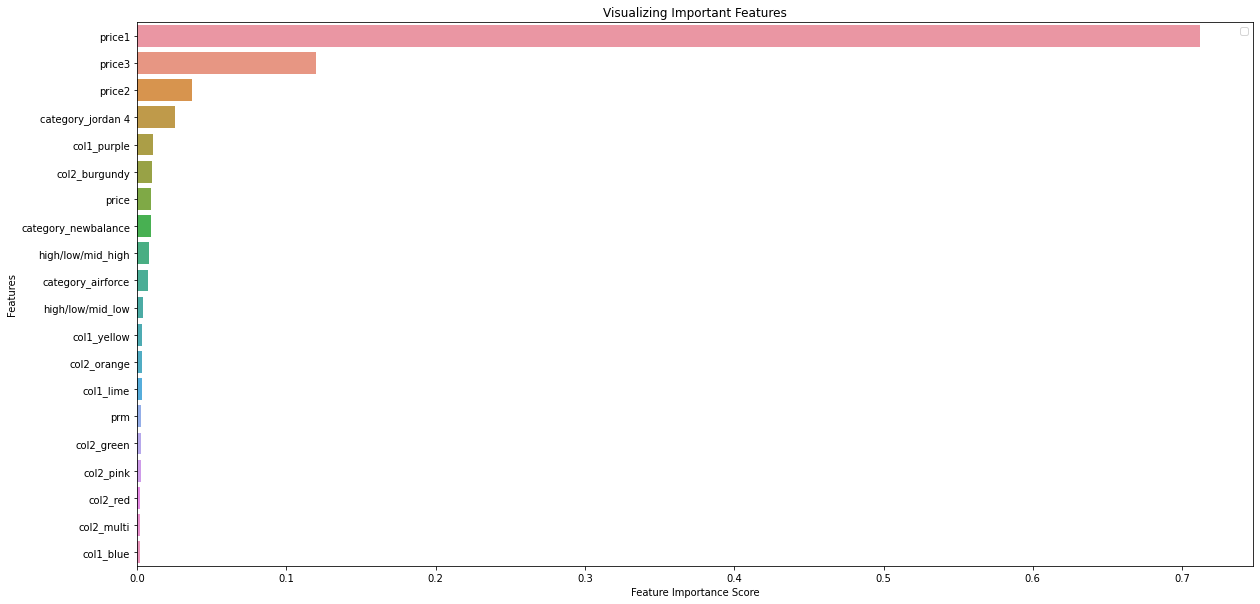

In [22]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Shap Value

### feature importance

In [23]:
import shap

In [24]:
## 제작한 모델을 TreeExplainer 함수에 넣고, 학습한 train 데이터를 shap_values 함수에
## 우리가 원하는 변수중요도가 추출
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values( data[data_a] )

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


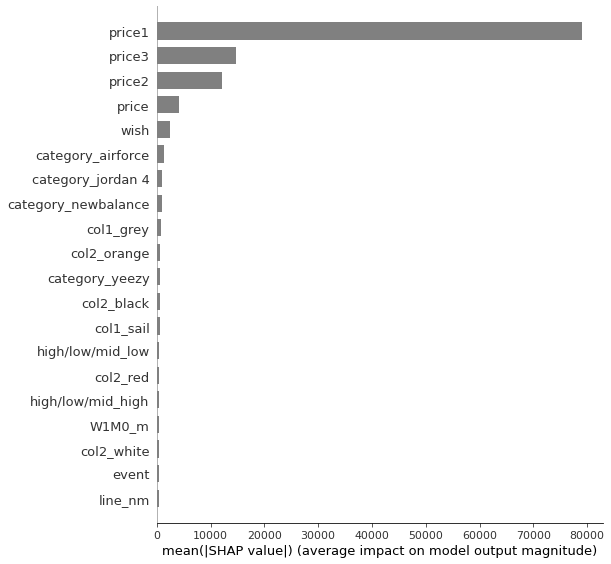

In [25]:
shap.summary_plot( shap_values , data[data_a] , plot_type="bar" , color= 'grey')

### dependence plot

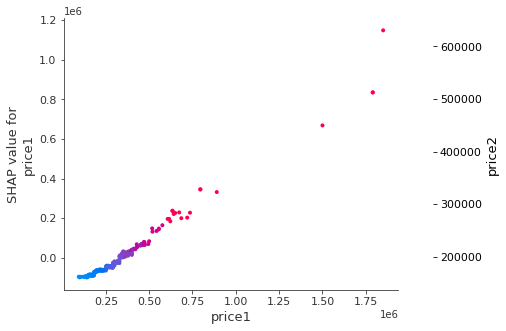

In [26]:
## dependence_plot 함수는 특정 input 변수와 target 변수와의 관계를 표현하는 dependence plot을 그려주는 함수
shap.dependence_plot( 'price1' , shap_values , data[data_a] )

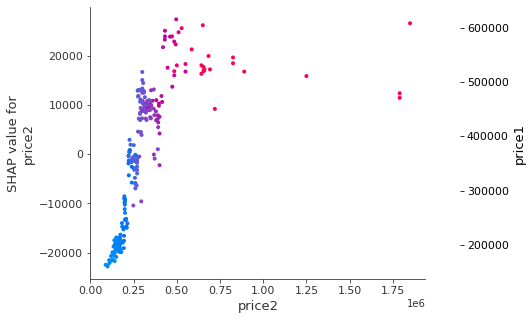

In [27]:
shap.dependence_plot( 'price2' , shap_values , data[data_a] )

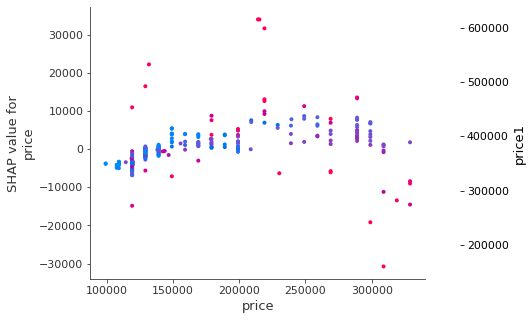

In [28]:
shap.dependence_plot( 'price' , shap_values , data[data_a] )

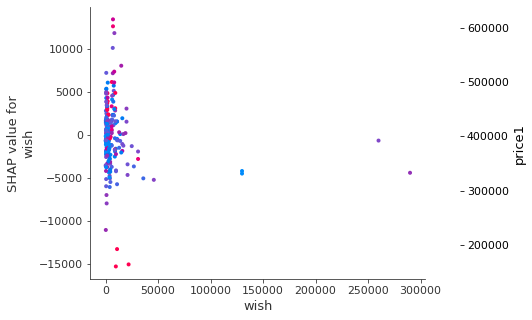

In [29]:
shap.dependence_plot( 'wish' , shap_values , data[data_a] )

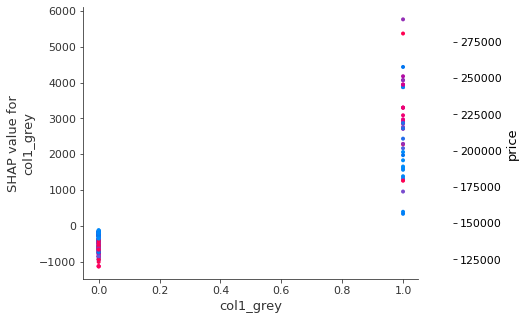

In [30]:
shap.dependence_plot( 'col1_grey' , shap_values , data[data_a] )